In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import resample
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg
)
from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


class RppgMl:
    
    def __init__(self, data, label_col = 'bvp', test_size = 0.2, random_state = 0):

        self.data = data
        self.label_col = label_col
        self.test_size = test_size
        self.random_state = random_state

        self.X = self.data.drop(columns = [self.label_col])
        self.y = self.data[self.label_col]
        
        (
            self.X_train, self.X_test,
            self.y_train, self.y_test
        ) = train_test_split(self.X, self.y, test_size = self.test_size, random_state = self.random_state)

        self.X_train = self.X_train.to_numpy()
        self.X_test = self.X_test.to_numpy()
        self.y_train = self.y_train.to_numpy()
        self.y_test = self.y_test.to_numpy()
    
    def train_skl(self, model):
        self.skl_model = model(random_state = self.random_state)
        self.skl_model.fit(self.X_train, self.y_train)

    def predict_skl(self, x):
        return self.skl_model.predict(x)
    
    def eval_skl(self):
        return mean_squared_error(self.y_test, self.predict_skl(self.X_test))

In [3]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')  # basic method
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [7]:
data_arr = []
for i in range(len(truths)):
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data_arr.append(data)
data = pd.concat(data_arr)

ml = RppgMl(data)
print(f'Training on {len(ml.X_train)} samples')
ml.train_skl(RandomForestRegressor)
ml.eval_skl()

Training on 109426 samples


0.009773662504671411

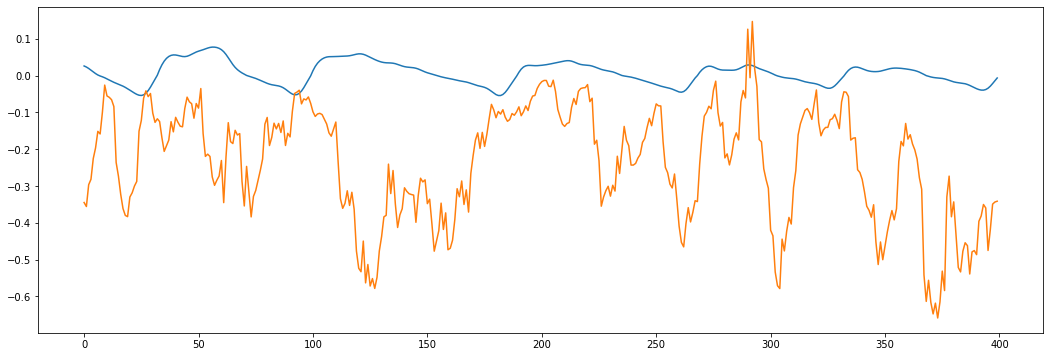

In [5]:
test_subject = 1
test_data = truths[test_subject - 1].prepare_data_for_ml()
test_X = test_data.drop(columns = ['bvp']).to_numpy()
test_y = test_data.bvp.to_numpy()


pred = ml.predict_skl(test_X)
pred = n_moving_avg(pred, 3)
pred = resample(pred, len(test_y))
# pred = normalize_amplitude_to_1(pred)

beg = 400
end = 800
plt.plot(test_y[beg: end])
plt.plot(pred[beg: end])

# interval = 400
# for beg in range(0, len(test_y), interval):
#     end = beg + interval
#     plt.plot(test_y[beg: end])
#     plt.plot(pred[beg: end])
#     plt.show()

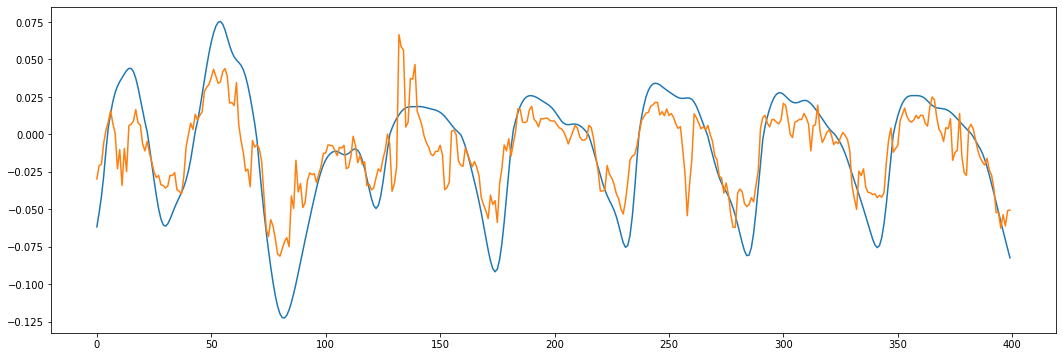

In [6]:
test_X = ml.X.to_numpy()
test_y = ml.y.to_numpy()
subj_len = len(test_y)


pred = ml.predict_skl(test_X)
pred = n_moving_avg(pred, 3)
pred = resample(pred, len(test_y))

beg = 400
end = 800
plt.plot(test_y[beg: end])
plt.plot(pred[beg: end])

# interval = 400
# for beg in range(0, subj_len, interval):
#     end = beg + interval
#     plt.plot(data.bvp.to_numpy()[beg: end])
#     plt.plot(pred[beg: end])
#     plt.show()
